In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
from nilearn import plotting
from nilearn import image
import nibabel as nib
import subprocess
import nipype
%matplotlib inline

In [3]:
import sys
!{sys.executable} -m pip install deepbrain

  Using cached deepbrain-0.1-py3-none-any.whl (677 kB)
  Using cached tensorflow-2.2.0-cp37-cp37m-win_amd64.whl (459.2 MB)


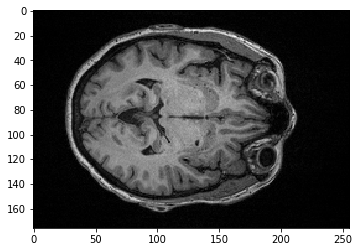

In [2]:
scans_path = "D:/OASIS/scansFILES"
list_of_labels = os.listdir(scans_path)

def load_img(label_num, img_num):
    label_path = os.path.join(scans_path,list_of_labels[label_num])
    list_of_img = os.listdir(label_path)
    img_path = os.path.join(label_path,list_of_img[img_num])
    
    img1 = nib.load(os.path.join(scans_path, label_path, list_of_img[img_num]))
    data = img1.get_fdata()
    plot = plt.imshow(data[:,:,124],cmap='gray')
    
    return plot

load_img(0,0)

In [6]:
def img(label_num, img_num):
    label_path = os.path.join(scans_path,list_of_labels[label_num])
    list_of_img = os.listdir(label_path)
    img_path = os.path.join(label_path,list_of_img[img_num])
    
    img1 = nib.load(os.path.join(scans_path, label_path, list_of_img[img_num]))
    return img1

In [8]:
from deepbrain import Extractor

img = nib.load(img(0,0)).get_fdata()

ext = Extractor()
prob = ext.run(img)

mask = prob > 0.5

ImportError: Traceback (most recent call last):
  File "C:\Users\srihi\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\srihi\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\srihi\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\srihi\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\srihi\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
from skimage import filters

def imgshow():
    label_path = os.path.join(scans_path,list_of_labels[0])
    list_of_img = os.listdir(label_path)
    img_path = os.path.join(label_path,list_of_img[0])
    
    img1 = nib.load(os.path.join(scans_path, label_path, list_of_img[0]))
    data = img1.get_fdata()
    return data

im = imgshow()[:,:,124]
val = filters.threshold_otsu(im[im>0])
plt.imshow(im>val)

In [ ]:
from skimage import filters
from skimage import measure
from skimage import morphology

thresh = filters.threshold_otsu(im[im>0])
volBW = im > thresh
components, n = measure.label(volBW, return_num = True, connectivity = 2)

w,h = components.shape[0], components.shape[1]
edges = np.ravel([components[0,:], components[w-1,:], components[:,0], components[:,h-1]])
    
for x in edges:
    components[components == x] = 0
        
for y in range(n):
    if len(components[components == y]) < 100:
        components[components == y] = 0
            
components[components>0] = 1
smoothed = morphology.binary_closing(components)

plt.imshow(smoothed)

In [11]:
def create_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        
def bet(src_path, dst_path, frac="0.5"):
    command = ["bet", src_path, dst_path, "-R", "-f", frac, "-g", "0"]
    subprocess.call(command)
    return


def unwarp_strip_skull(arg, **kwarg):
    return strip_skull(*arg, **kwarg)


def strip_skull(src_path, dst_path, frac="0.4"):
    print("Working on :", src_path)
    try:
        bet(src_path, dst_path, frac)
    except RuntimeError:
        print("\tFailed on: ", src_path)

    return


parent_dir = os.path.dirname("D:")
data_dir = os.path.join(parent_dir, "OASIS")
data_src_dir = os.path.join(data_dir, "scansFILES")
data_dst_dir = os.path.join(data_dir, "scansFILES1")
data_labels = ["0", "0.5", "1", "2", "3"]
create_dir(data_dst_dir)

data_src_paths, data_dst_paths = [], []
for label in data_labels:
    src_label_dir = os.path.join(data_src_dir, label)
    dst_label_dir = os.path.join(data_dst_dir, label)
    create_dir(dst_label_dir)
    for scan in os.listdir(src_label_dir):
        data_src_paths.append(os.path.join(src_label_dir, scan))
        data_dst_paths.append(os.path.join(dst_label_dir, scan))

strip_skull(data_src_dir[0], data_dst_dir[0])

Working on : D


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
def registration(src_path, dst_path, ref_path):
    command = ["flirt", "-in", src_path, "-ref", ref_path, "-out", dst_path,
               "-bins", "256", "-cost", "corratio", "-searchrx", "0", "0",
               "-searchry", "0", "0", "-searchrz", "0", "0", "-dof", "12",
               "-interp", "spline"]
    subprocess.call(command, stdout=open(os.devnull, "r"),
                    stderr=subprocess.STDOUT)
    return

def main(src_path, dst_path, ref_path):
    print("Registration on: ", src_path)
    try:
        registration(dst_path, dst_path, ref_path)
    except RuntimeError:
        print("\tFalied on: ", src_path)

    return

parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, "scans")
data_src_dir = os.path.join(data_dir, "ADNI")
data_dst_dir = os.path.join(data_dir, "ADNIReg")
data_labels = ["AD", "NC"]
create_dir(data_dst_dir)

ref_path = os.path.join(data_dir, "Template", "MNI152_T1_1mm.nii.gz")
# ref_path = os.path.join(data_dir, "Template", "MNI152_T1_1mm_brain.nii.gz")

data_src_paths, data_dst_paths = [], []
for label in data_labels:
    src_label_dir = os.path.join(data_src_dir, label)
    dst_label_dir = os.path.join(data_dst_dir, label)
    create_dir(dst_label_dir)
    for subject in os.listdir(src_label_dir):
        data_src_paths.append(os.path.join(src_label_dir, subject))
        data_dst_paths.append(os.path.join(dst_label_dir, subject))

ref_path = os.path.join(data_dir, "Template", "MNI152_T1_1mm.nii.gz") #img
main(data_src_paths[0], data_dst_paths[0], ref_path)

In [ ]:
()